In [15]:
library(mvtnorm)
library(DAAG)



# FUNCTIONS ---------------------------------------------------------------


### split data into test and training sets
# df:         data set
# train_amt:  proportion of data to use for training
# resp_idx:   which column the class variable is (for breast cancer data this is 10)
split_data <- function(df, train_amt, resp_idx) {
  N <- floor(nrow(df) * train_amt)
  ind <- sample.int(nrow(df), size = N)
  x_train <- as.matrix(df[ind,-resp_idx])
  x_test <- as.matrix(df[-ind,-resp_idx])
  class_train <- df[ind,resp_idx]
  class_test <- df[-ind,resp_idx]
  return(list(x_train = x_train,
              x_test = x_test,
              class_train = class_train,
              class_test = class_test))
}

### EM algorithm
# x:      covariates (as a matrix, one row = one observation)
# y:      response (as a factor)
# R:      number of subclasses for each class
# tol:    condition for convergence
# maxit:  maximum number of iterations for EM to run
EM <- function(x, y, R, tol = 1e-6, maxit = 10) {
  labs <- levels(y)
  K <- length(labs)
  M <- ncol(x)
  N <- nrow(x)
  pi <- array(0, dim = c(K, R))
  mu <- array(0, dim = c(K, M, R))
  sigma <- diag(M)
  y <- as.numeric(y)
  ### come up with starting points using kmeans
  for(k in 1:K) {
    ind <- which(y == k)
    mu[k, , ] <- t(kmeans(x[ind, ], R)$centers)
    pi[k, ] <- rep(1/R, length = R)
  }
  converged <- F
  ### main EM loop
  # while(!converged) {
  for(it in 1:maxit) {
    # E step
    p <- array(0, dim = c(N, R))
    for(i in 1:N) {
      k <- y[i]
      for(r in 1:R) {
        p[i,r] <- pi[k,r] * dmvnorm(x[i, ], mu[k, ,r], sigma)
      }
      p[i, ] <- p[i, ]/sum(p[i, ])
    }
    # M step
    for(k in 1:K) {
      ind <- which(y == k)
      for(r in 1:R) {
        pi[k,r] <- sum(p[ind,r])/length(ind)
        mu[k, ,r] <- colSums(x[ind, ]*p[ind,r])/sum(p[ind,r])
      }
    }
    tally <- 0
    for(i in 1:N) {
      z <- y[i]
      for(r in 1:R) {
        tmp <- x[i, ] - mu[z, ,r]
        tally <- tally + p[i,r] * (tmp %o% tmp)
      }
    }
    sigma <- tally/N
    # check convergence

  }
  return(list(pi = pi,
              mu = mu,
              sigma = sigma,
              class_labels = labs))
}

### predict classes
# em: object from the result of EM function above
# x: new data (as a matrix, one row = one observation)
em_predict <- function(em, x) {
  pi <- em$pi
  mu <- em$mu
  sigma <- em$sigma
  labs <- em$class_labels
  K <- dim(mu)[1]
  R <- dim(mu)[3]
  classes <- rep(NA, nrow(x))

  for(i in 1:nrow(x)) {
    probs <- rep(0, K)
    for(k in 1:K) {
      for(r in 1:R) {
        probs[k] <- probs[k] + pi[k,r] * dmvnorm(x[i, ], mean = mu[k, ,r], sigma = sigma)
      }
    }
    classes[i] <- which.max(probs)
  }
  return(factor(classes, labels = labs))
}



In [16]:
# DATA CLEANING -----------------------------------------------------------


# read data in and format it
data <- read.csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header = F, na.strings = '?')
names(data) <- c('id','thickness','size.unif','shape.unif','adhesion','size.cell','nuclei','chromatin','nucleoli','mitoses','class')
data$class <- as.factor(data$class)
levels(data$class) <- c('benign','malignant')
data <- data[-which(is.na(data$nuclei)),-1] # leave ID column out and remove NAs


# 1 subclass

In [17]:
# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 1 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)


Overall accuracy = 0.978 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.971     0.029
  malignant  0.010     0.990


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.974 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.966     0.034
  malignant  0.010     0.990


# 2 sublcasses 

In [18]:
# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 2 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)


Overall accuracy = 0.971 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.984     0.016
  malignant  0.055     0.945


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.967 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.984     0.016
  malignant  0.065     0.935


# 3 sublcasses

In [19]:


# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 3 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)



Overall accuracy = 0.953 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.952     0.048
  malignant  0.047     0.953


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.971 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.983     0.017
  malignant  0.054     0.946


Warning message:
In plot.window(...): "alpha" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "alpha" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): "alpha" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): "alpha" is not a graphical parameterWarning message:
In box(...): "alpha" is not a graphical parameterWarning message:
In title(...): "alpha" is not a graphical parameter

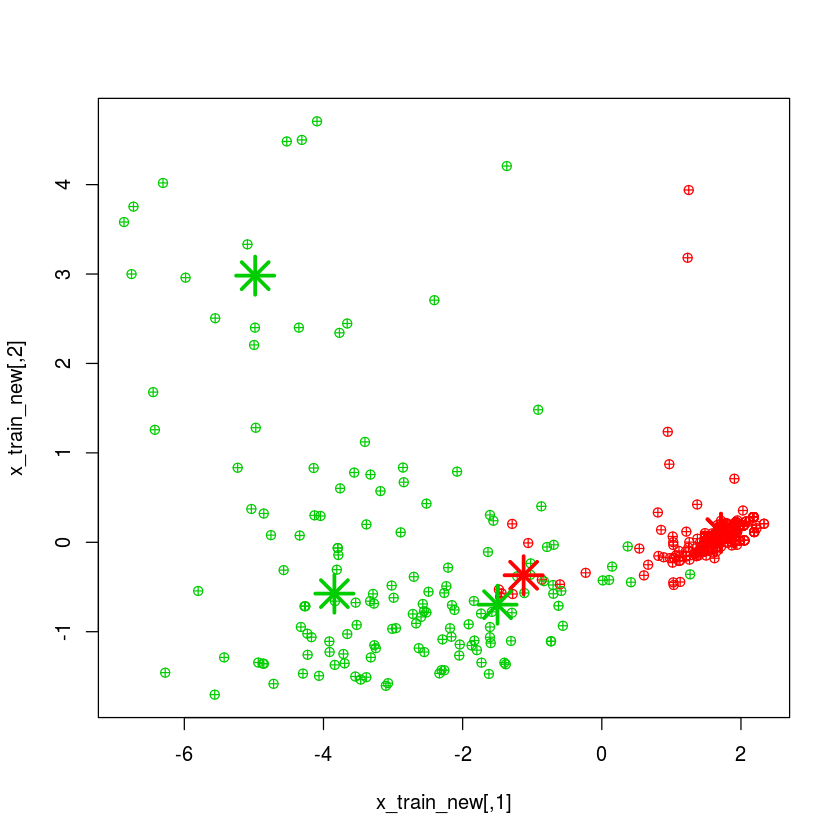

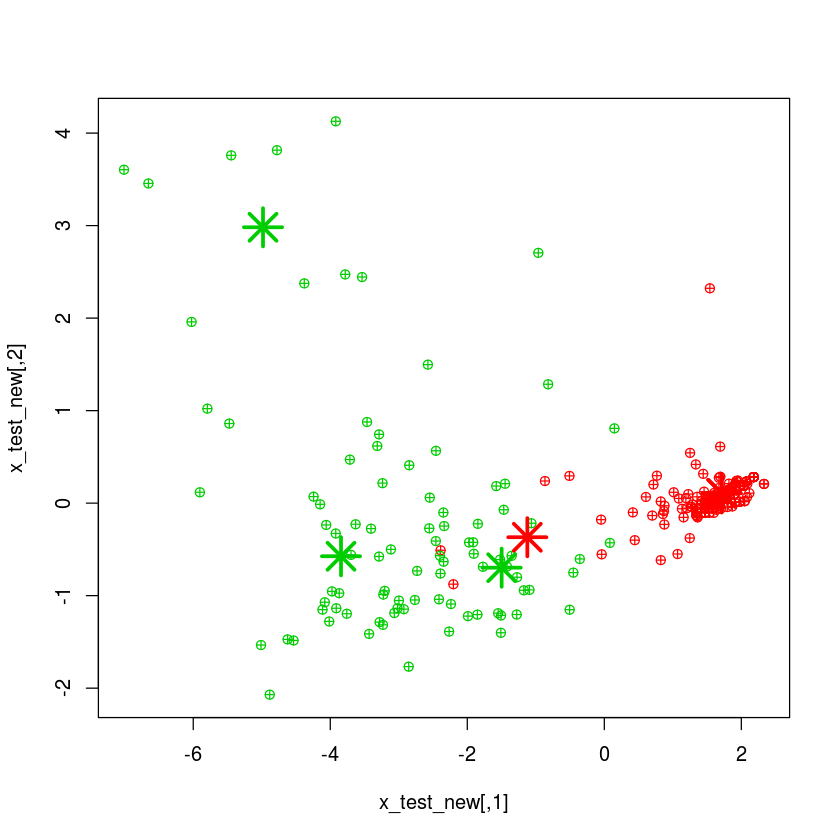

In [20]:
0.974 0.967 0.971 
plot(x_train_new, pch = 10, alpha = 0.5, col = as.numeric(class_train)+1)
points(t(fit2$mu[1, , ]), pch = 8, cex = 3, lwd = 3, col = 2)
points(t(fit2$mu[2, , ]), pch = 8, cex = 3, lwd = 3, col = 3)
plot(x_test_new, pch = 10, col = as.numeric(class_test)+1)
points(t(fit2$mu[1, , ]), pch = 8, cex = 3, lwd = 3, col = 2)
points(t(fit2$mu[2, , ]), pch = 8, cex = 3, lwd = 3, col = 3)

# 4 components 

In [21]:


# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 4 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)

Overall accuracy = 0.967 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.972     0.028
  malignant  0.043     0.957


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.967 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.978     0.022
  malignant  0.052     0.948


# 5 components

In [22]:

# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 5 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)

Overall accuracy = 0.964 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.974     0.026
  malignant  0.062     0.938


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.964 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.989     0.011
  malignant  0.092     0.908


# 6 components


In [23]:

# SCRIPT ------------------------------------------------------------------
require(DAAG)

R <- 6 # number of subclasses
training_amount <- 0.6

X <- split_data(data, training_amount, 10)
x_train <- X$x_train
x_test <- X$x_test
class_train <- X$class_train
class_test <- X$class_test

# run MDA
fit <- EM(x_train, class_train, R)
# classify test data
fit_pred <- em_predict(fit, x_test)
# resulting confusion matrix and error rate
confusion(fit_pred, class_test)

# try PCA
x <- rbind(x_train, x_test)
x_scaled <- apply(x, 2, function(x) (x - mean(x))/sd(x))
eig <- eigen(cov(x_scaled))
eig$values/sum(eig$values)
V <- eig$vectors[ ,1:2]
x_new <- as.matrix(x_scaled %*% V)
x_train_new <- x_new[1:nrow(x_train), ]
x_test_new <- x_new[-(1:nrow(x_train)), ]

fit2 <- EM(x_train_new, class_train, R)
fit_pred2 <- em_predict(fit2, x_test_new)
confusion(fit_pred2, class_test)

Overall accuracy = 0.945 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.965     0.035
  malignant  0.087     0.913


[1] 0.655499928 0.086216321 0.059916916 0.051069717 0.042252870 0.033541828
[7] 0.032711413 0.028970651 0.009820358

Overall accuracy = 0.96 

Confusion matrix 
           Predicted (cv)
Actual      benign malignant
  benign     0.982     0.018
  malignant  0.075     0.925


In [7]:

# plot accuracy

ac1 <- c(0.978 ,0.971 ,0.953,0.967,0.964,0.945)
nclasses <- 1:6
jpeg('./report/mda_acc.jpeg')
plot(nclasses, ac1, type='l', xlab = "# components", ylab = "Accuracy")
dev.off()

pdf 
  2

In [33]:
# plot accuracy

ac1 <- c(0.974,0.967, 0.971, 0.967, 0.964, 0.96 )
nclasses <- 1:6
jpeg('./report/pca_acc.jpeg')
plot(nclasses, ac1, type='l', xlab = "# components", ylab = "Accuracy")
dev.off()

pdf 
  2